To setup a Bayesian model, we need to assign prior distributions to our unknown quantities. *A priori*, *B priori*, and *C priori*, what do we think $p_A$, $p_B$, and $p_C$ might be? For this example, we have no strong conviction about $p_A$, $p_B$, and $p_C$, so for now, let's assume $p_A$, $p_B$, and $p_C$, is uniform over [0,1]:

In [1]:
import pymc3 as pm
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
figsize(12.5, 4)


In [2]:
true_A = 120
true_B = 129
true_C = 84

N_sample = 1156


In [3]:
true_p_A = true_A/float(N_sample)
true_p_B = true_B/float(N_sample)
true_p_C = true_C/float(N_sample)

print("true p_A:", true_p_A)
print("true p_B:", true_p_B)
print("true p_C:", true_p_C)


true p_A: 0.10380622837370242
true p_B: 0.1115916955017301
true p_C: 0.0726643598615917


In [4]:
observations_A = stats.bernoulli.rvs(true_p_A, size=N_sample)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_sample)
observations_C = stats.bernoulli.rvs(true_p_C, size=N_sample)

print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")
print("Obs from Site C: ", observations_C[:30], "...")


Obs from Site A:  [0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site C:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [5]:
print(np.mean(observations_A))
print(np.mean(observations_B))
print(np.mean(observations_C))

print(np.sum(observations_A))
print(np.sum(observations_B))
print(np.sum(observations_C))

0.108996539792
0.10553633218
0.0640138408304
126
122
74


Applied interval-transform to p and added transformed p\_interval_ to model.

Had we had stronger beliefs, we could have expressed them in the prior above.
For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a *Bernoulli* distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data.

In [6]:
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    p_C = pm.Uniform("p_C", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta_A_B = pm.Deterministic("delta_A_B", p_A - p_B)
    delta_A_C = pm.Deterministic("delta_A_C", p_A - p_C)
    delta_B_C = pm.Deterministic("delta_B_C", p_B - p_C)
    
    # Set of observations, in this case we have three observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)
    obs_C = pm.Bernoulli("obs_C", p_C, observed=observations_C)

    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

100%|██████████| 20500/20500 [00:14<00:00, 1409.03it/s]


In [7]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
p_C_samples = burned_trace["p_C"]
delta_A_B_samples = burned_trace["delta_A_B"]
delta_A_C_samples = burned_trace["delta_A_C"]
delta_B_C_samples = burned_trace["delta_B_C"]

print(p_A_samples)
print(p_B_samples)
print(p_C_samples)
print(delta_A_B_samples)
print(delta_A_C_samples)
print(delta_B_C_samples)

[ 0.11433807  0.11433807  0.11433807 ...,  0.11769642  0.11769642
  0.11769642]
[ 0.11597607  0.10965325  0.10965325 ...,  0.10550852  0.10550852
  0.10550852]
[ 0.06142239  0.06142239  0.06142239 ...,  0.07131912  0.07131912
  0.07131912]
[-0.00163801  0.00468482  0.00468482 ...,  0.0121879   0.0121879   0.0121879 ]
[ 0.05291567  0.05291567  0.05291567 ...,  0.0463773   0.0463773   0.0463773 ]
[ 0.05455368  0.04823085  0.04823085 ...,  0.03418941  0.03418941
  0.03418941]


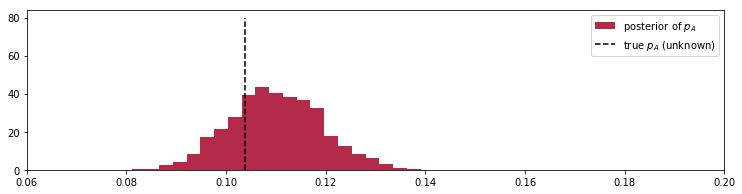

In [8]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(.06, .2)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")


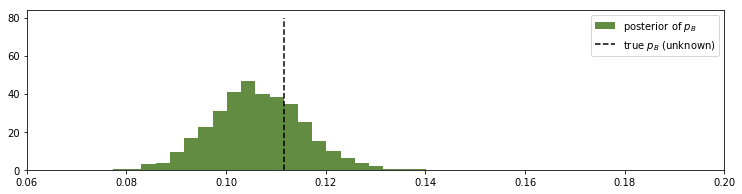

In [9]:
ax = plt.subplot(312)

plt.xlim(.06, .2)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")


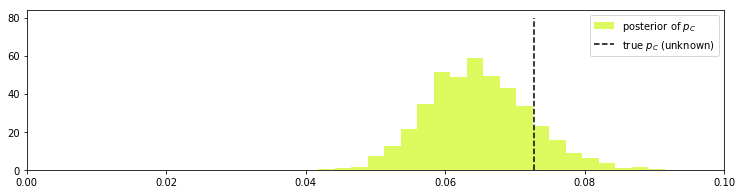

In [10]:
ax = plt.subplot(313)

plt.xlim(0, .1)
plt.hist(p_C_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_C$", color="#D6F841", normed=True)
plt.vlines(true_p_C, 0, 80, linestyle="--", label="true $p_C$ (unknown)")
plt.legend(loc="upper right")

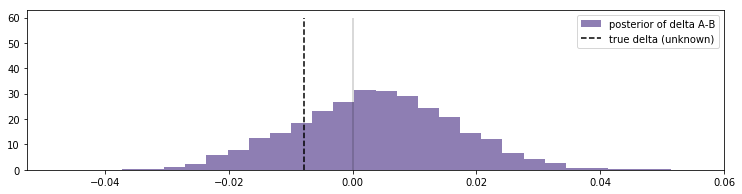

In [11]:
ax = plt.subplot(313)
plt.hist(delta_A_B_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta A-B", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

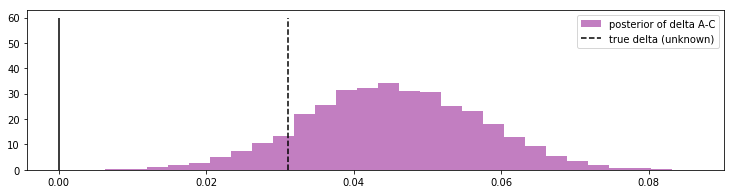

In [12]:


ax = plt.subplot(313)
plt.hist(delta_A_C_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta A-C", color="#B868B6", normed=True)
plt.vlines(true_p_A - true_p_C, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black")
plt.legend(loc="upper right");



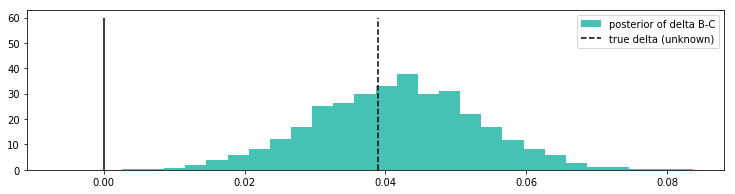

In [13]:
ax = plt.subplot(313)
plt.hist(delta_B_C_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta B-C", color="#24B8A6", normed=True)
plt.vlines(true_p_B - true_p_C, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black")
plt.legend(loc="upper right");

In [14]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_A_B_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_A_B_samples > 0))

print("\nProbability site A is WORSE than site C: %.3f" % \
    np.mean(delta_A_C_samples < 0))

print("Probability site A is BETTER than site C: %.3f \n" % \
    np.mean(delta_A_C_samples > 0))

print("Probability site B is WORSE than site C: %.3f" % \
    np.mean(delta_B_C_samples < 0))

print("Probability site B is BETTER than site C: %.3f" % \
    np.mean(delta_B_C_samples > 0))

Probability site A is WORSE than site B: 0.382
Probability site A is BETTER than site B: 0.618

Probability site A is WORSE than site C: 0.000
Probability site A is BETTER than site C: 1.000 

Probability site B is WORSE than site C: 0.000
Probability site B is BETTER than site C: 1.000
